# Bond Options Hull White Model

In [1]:
import sys
sys.path.append("..")
sys.path.append("..\\..")

In [2]:
from importlib import reload

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
from financepy.finutils.FinDate import FinDate
from financepy.models.FinHullWhiteRateModel import FinHullWhiteRateModel
from financepy.finutils.FinHelperFunctions import printTree
from financepy.market.curves.FinDiscountCurve import FinDiscountCurve
from financepy.products.bonds.FinBond import FinBond
from financepy.finutils.FinFrequency import FinFrequencyTypes
from financepy.finutils.FinDayCount import FinDayCountTypes
from financepy.finutils.FinGlobalVariables import gDaysInYear

## Example from Hull Book

The first test is to price an option on a zero coupon bond as this has an analytical solution. Hull gives the following information for the term structure of interest rates.

In [5]:
zeroDays = [0, 3, 31, 62, 94, 185, 367, 731, 1096, 1461, 1826, 2194, 2558, 2922, 3287, 3653]
zeroRates = [5.0, 5.01772, 4.98282, 4.97234, 4.96157, 4.99058, 5.09389, 5.79733, 6.30595, 6.73464, 
             6.94816, 7.08807, 7.27527, 7.30852, 7.39790, 7.49015]

Create the discount curve

In [6]:
startDate = FinDate(1, 12, 2019)
times = np.array(zeroDays) / 365.0
zeros = np.array(zeroRates) / 100.0
dfs = np.exp(-zeros*times) 
discountCurve = FinDiscountCurve(startDate, times, dfs)

Set the model parameters

In [7]:
sigma = 0.01
a = 0.1
model = FinHullWhiteRateModel(a, sigma)

Set the option parameters

In [8]:
strike = 63.0
face = 100.0
expiryDate = startDate.addTenor("3Y")
maturityDate = startDate.addTenor("9Y")

In [9]:
vAnal = model.europeanOptionOnZeroCouponBond_Anal(startDate, expiryDate, maturityDate, 
                                                  strike, face, discountCurve)

In [10]:
# Test convergence
numStepsList = range(100, 500, 10)
analVector = []
treeVector = []

for numTimeSteps in numStepsList:
    start = time.time()
    model.buildTree(startDate, expiryDate, numTimeSteps, discountCurve)
    vTree = model.europeanOptionOnZeroCouponBond_Tree(startDate,
                                                      expiryDate,
                                                      maturityDate,
                                                      strike, face)
    end = time.time()
    period = end-start
    treeVector.append(vTree[1])
    analVector.append(vAnal[1])
    print(numTimeSteps, vTree[1], vAnal[1], period)    

100 1.8182444957901762 1.8130297564101916 0.02799391746520996
110 1.8181166973972578 1.8130297564101916 0.007997989654541016
120 1.817805380063026 1.8130297564101916 0.005002737045288086
130 1.8173755054208085 1.8130297564101916 0.007001399993896484
140 1.8168696367998542 1.8130297564101916 0.007997274398803711
150 1.8163162525535528 1.8130297564101916 0.006997346878051758
160 1.8157347172796714 1.8130297564101916 0.009996891021728516
170 1.8151383553382172 1.8130297564101916 0.010996103286743164
180 1.814536406161615 1.8130297564101916 0.010994911193847656
190 1.8139352990259874 1.8130297564101916 0.008997440338134766
200 1.8133395021369214 1.8130297564101916 0.011995553970336914
210 1.8127520988287067 1.8130297564101916 0.012991189956665039
220 1.8128636519617385 1.8130297564101916 0.012992620468139648
230 1.8133539445802542 1.8130297564101916 0.015995025634765625
240 1.81374889848921 1.8130297564101916 0.016994714736938477
250 1.8140629790411935 1.8130297564101916 0.0189940929412841

Plot the convergence

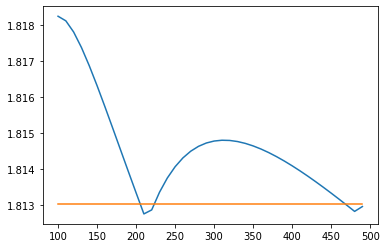

In [11]:
plt.plot(numStepsList, treeVector)
plt.plot(numStepsList, analVector)

This agrees almost exactly with what was calculated in the book. It only differs due to slightly different times due to my way of calculating years internally.

# American Bond Option Valuation

We value an American style option on a coupon paying bond.

In [12]:
settlementDate = FinDate(1, 12, 2019)

The bond pays 5% semi-annually for 10 years.

In [13]:
maturityDate = settlementDate.addTenor("10Y")
coupon = 0.05
frequencyType = FinFrequencyTypes.SEMI_ANNUAL
accrualType = FinDayCountTypes.ACT_ACT_ICMA
bond = FinBond(maturityDate, coupon, frequencyType, accrualType)

The option expires in 18 months with a strike of 105

In [14]:
expiryDate = settlementDate.addTenor("18m")
strikePrice = 105.0
face = 100.0

We set the HW model to have 1% of basis point volatility and 0.1 of mean-reversion

In [15]:
sigma = 0.01
a = 0.1

We set up a flat discount curve at 5%

In [16]:
tmat = (maturityDate - settlementDate) / gDaysInYear
times = np.linspace(0, tmat, 20)
dfs = np.exp(-0.05*times)
discountCurve = FinDiscountCurve(settlementDate, times, dfs)

We can price the basic bond without any option

In [17]:
price = bond.fullPriceFromDiscountCurve(settlementDate, discountCurve)

In [18]:
print("Bond Price:", price)

Bond Price: 99.50391846904128


Now we price the option - the tree only needs to go out to the expiry date of the option

In [19]:
numTimeSteps = 100

In [33]:
model = FinHullWhiteRateModel(a, sigma)

In [30]:
numStepsList = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000]

50 1.0195442666210932 99.50481770183933
100 1.0461115527082683 99.50436862745435
150 0.9952437343691435 99.50421869503691
200 1.0582299351394304 99.5041436836449
250 1.0484865554556992 99.50409866239734
300 1.0898231214741718 101.82338385958747
400 1.0170068705340183 99.50403111024605
500 1.0568624726985643 99.50400858748012
600 1.0478861244253581 99.50399357070164
700 1.056208571044406 99.50398284364438
800 0.9930580734428299 99.50397479809263
900 1.0173848403666026 99.50396854057577
1000 1.05677600255145 99.50396353354103


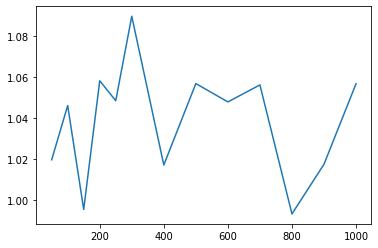

In [32]:
treeVector = []
for numTimeSteps in numStepsList:
    model = FinHullWhiteRateModel(a, sigma)
    model.buildTree(settlementDate, expiryDate, numTimeSteps, discountCurve)
    vOption, vBond = model.bondOption(settlementDate, expiryDate, strikePrice, face, bond, True)
    treeVector.append(vOption)
    print(numTimeSteps, vOption, vBond)

plt.plot(numStepsList, treeVector);    

There is a convergence issue at 300 steps with the bond price that needs to be examined. It relates to a numerical issue regarding the coupon payment and expiry date being close together.